# Transfer Learning
From previous lectures, we successfully classified image data using Convolutional Neural Networks. However, training an entire CNN from scratch will require a lot of computing time and a large dataset to reach high accuracies. Instead, we use the knowledge gained from the pretrained networks on a large dataset (ImageNet, which contains 1.2 million images with 1000 categories) and customize this model for our model by changing the last layers.
<br><br>
We will use the dataset below in this example. <br>
https://www.kaggle.com/piyushkumar18/animal-image-classification-dataset

You can refer to the pytorch website on how to call these models: <br>
https://pytorch.org/vision/stable/models.html

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
import torchvision.models as models
import cv2
import numpy as np
from matplotlib import pyplot as plt
from math import floor
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


## Loading and Preparing Data

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [2]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

In [3]:
transform = transforms.Compose([
    # the sizes of all images should be the same
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # normalizing the images
    transforms.Normalize(mean=MEAN, std=STD)
])

dataset = torchvision.datasets.ImageFolder(root='Animal Image Dataset', transform=transform)
print(dataset.class_to_idx)

images_num = len(dataset)
print(images_num)

train_data, test_data = torch.utils.data.random_split(dataset, [floor(images_num * 0.85) + 1, floor(images_num * 0.15)])

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

{'butterfly': 0, 'cats': 1, 'cow': 2, 'dogs': 3, 'elephant': 4, 'hen': 5, 'horse': 6, 'monkey': 7, 'panda': 8, 'sheep': 9, 'spider': 10, 'squirrel': 11}
17176


### Calling the pretrained resnet18 model

In [4]:
# calling the pretrained resnet18 model
model_resnet18 = models.resnet18(pretrained=True)
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# freezing the pretrained layers to save time and avoid unnecessary computing
for param in model_resnet18.parameters():
    param.requires_grad = False

In [6]:
# changing the last fully connected layer
n_of_features = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(n_of_features, 12)
model_resnet18 = model_resnet18.to(device)

### Training

In [7]:
# training the model on our dataset
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters())
epochs = 3

for epoch in range(epochs):
    model_resnet18.train()
    loss_sum = 0
    for i, (img, label) in enumerate(train_loader):
        img = img
        label = label
        optimizer.zero_grad()
        outputs = model_resnet18(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/(i+1):.4f}\t({100*(i+1)/len(train_loader):.0f}%)", end='\r')
    model_resnet18.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img = img
            label = label
            outputs = model_resnet18(img)
            loss = criterion(outputs, label)
            valid_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}\tLoss:{loss_sum/len(train_loader):.4f}\tValidation Loss:{valid_loss/len(test_loader):.4f}")

Epoch 1/3	Loss:0.5374	Validation Loss:0.2054
Epoch 2/3	Loss:0.2072	Validation Loss:0.1576
Epoch 3/3	Loss:0.1700	Validation Loss:0.1425


### Testing

correct answers: 2456 out of 2576
accuracy is: 0.953416149068323


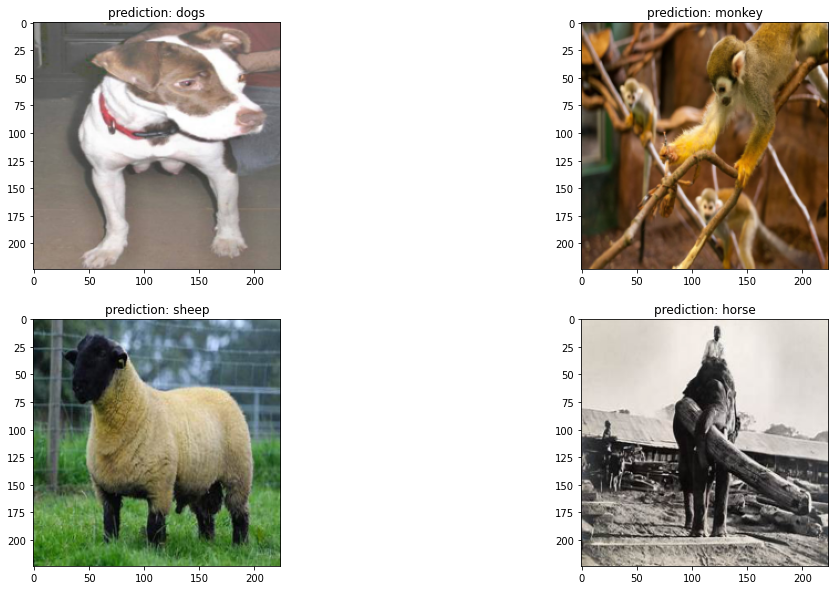

In [8]:
correct =0
total=0
stop = False
with torch.no_grad():
    for i, (img, label) in enumerate(test_loader):
        img = img
        label = label
        outputs = model_resnet18(img)
        for idx, j in enumerate(outputs):
            if torch.argmax(j) == label[idx]:
                correct +=1
            total += 1
            # i is the batch number that we want to print some sample images from
            # it can be any integer between 0 and len(test_loader)-1
            if i == 0 and stop == False:
                stop = True
                plt.figure(figsize=(18,10))
                for index in range(1, 5):
                    # renormalizing the images to print them in matplotlib
                    img[index-1] = img[index-1] * STD[:, None, None] + MEAN[:, None, None]
                    plt.subplot(2,2,index)
                    plt.imshow(img[index-1].permute(1, 2, 0))
                    plt.title("prediction: %s" %test_data.dataset.classes[outputs[index-1].argmax().numpy()])
print("correct answers:", correct, "out of", total)
print("accuracy is:", correct/total)
plt.show()

## Your Turn
Using vgg16, train the model on the same dataset and compare the results with resnet18.